In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

sns.set_style('whitegrid')

# Data cleaning!!

In [3]:
# Loading the df_whole dataset
df = pd.read_csv('/Users/kishohars/Projects/football_valuation_project/data_clean/df_whole.csv')

df.rename(columns = {'current_club_id_y': 'current_club_id', 'market_value_in_eur_y': 'market_value_in_eur'}, inplace = True)

df = df.drop(columns = 'current_club_id_x')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28462 entries, 0 to 28461
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             28462 non-null  int64  
 1   name                                  28462 non-null  object 
 2   last_season                           28462 non-null  int64  
 3   player_code                           28462 non-null  object 
 4   country_of_citizenship                28462 non-null  object 
 5   sub_position                          28462 non-null  object 
 6   position                              28462 non-null  object 
 7   foot                                  28462 non-null  object 
 8   height_in_cm                          28462 non-null  float64
 9   current_club_domestic_competition_id  28462 non-null  object 
 10  current_club_name                     28462 non-null  object 
 11  highest_market_

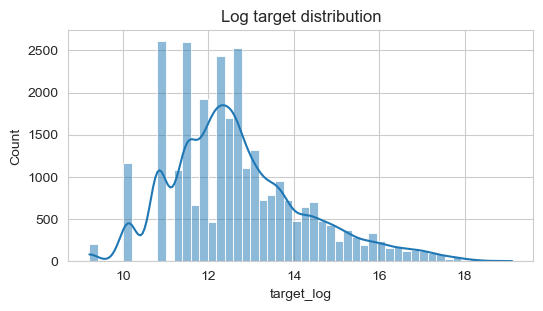

In [4]:
# target skew
df['target_log'] = np.log1p(df['market_value_in_eur'])

plt.figure(figsize=(6,3))
sns.histplot(df['target_log'], bins=50, kde = True)
plt.xlabel('target_log')
plt.ylabel('Count')
plt.title('Log target distribution'); plt.show()

In [5]:
# drop columns we won't use!!

drop_cols = ['player_id','name','player_name','player_code', 'current_club_name','contract_expiration_date','agent_name']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns = c, inplace = True)

# numeric and categorical lists!!

numeric_cols = df.select_dtypes(include = ['int64','float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['market_value_in_eur','target_log']]
cat_cols = df.select_dtypes(include = ['object','category']).columns.tolist()

numeric_cols, cat_cols[:10]

(['last_season',
  'height_in_cm',
  'highest_market_value_in_eur',
  'age',
  'current_club_id',
  'minutes_played',
  'goals',
  'assists',
  'yellow_cards',
  'red_cards',
  'goals_per90',
  'assists_per90'],
 ['country_of_citizenship',
  'sub_position',
  'position',
  'foot',
  'current_club_domestic_competition_id'])

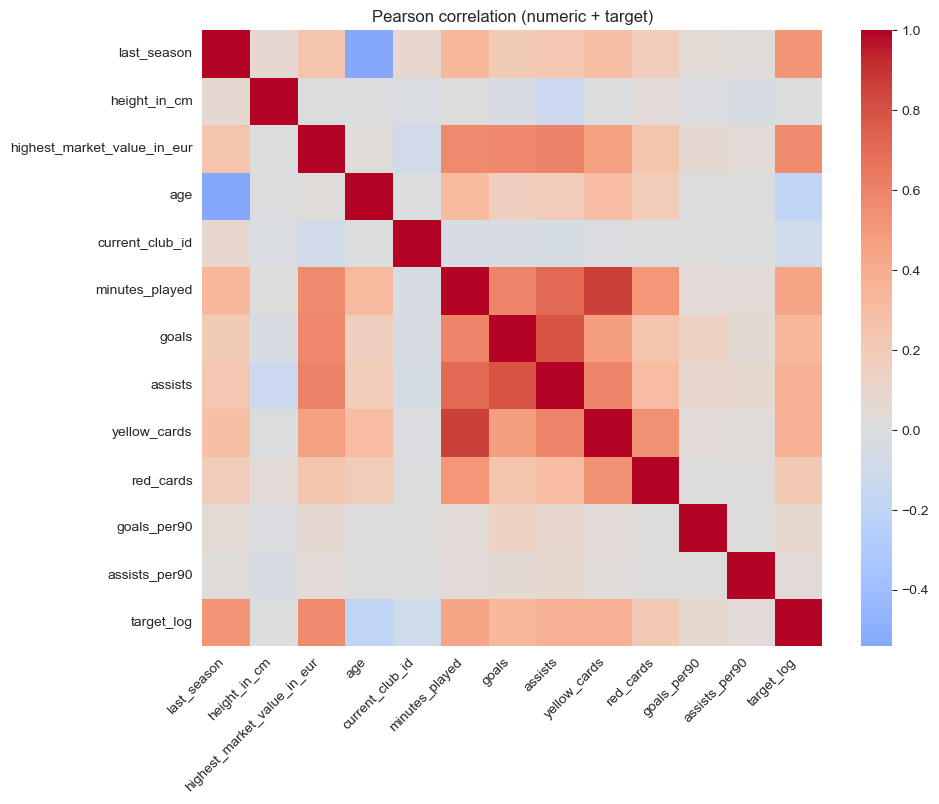

target_log                     1.000000
highest_market_value_in_eur    0.753807
last_season                    0.560679
minutes_played                 0.540526
yellow_cards                   0.487779
assists                        0.467962
goals                          0.465261
assists_per90                  0.418249
goals_per90                    0.413375
red_cards                      0.234047
height_in_cm                  -0.004846
age                           -0.168516
current_club_id               -0.194979
Name: target_log, dtype: float64

In [6]:
# Pearson heatmap (numeric features)!!
plt.figure(figsize=(10,8))
corr = df[numeric_cols + ['target_log']].corr(method = 'pearson')
sns.heatmap(data = corr, cmap = 'coolwarm', center=0)
plt.title('Pearson correlation (numeric + target)')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

# Spearman (robust to non-linear monotonic)!!
spearman = df[numeric_cols + ['target_log']].corr(method='spearman')['target_log'].sort_values(ascending=False)
spearman

In [7]:
# drop numeric pairs with abs(corr) > 0.85 (keep one of a pair)!!

high_corr = corr.abs()
high_pairs = np.where((high_corr > 0.85) & (high_corr < 1.0))
pairs = [(numeric_cols[i], numeric_cols[j]) for i,j in zip(*high_pairs) if i < j]
pairs[:10]

[('minutes_played', 'yellow_cards')]

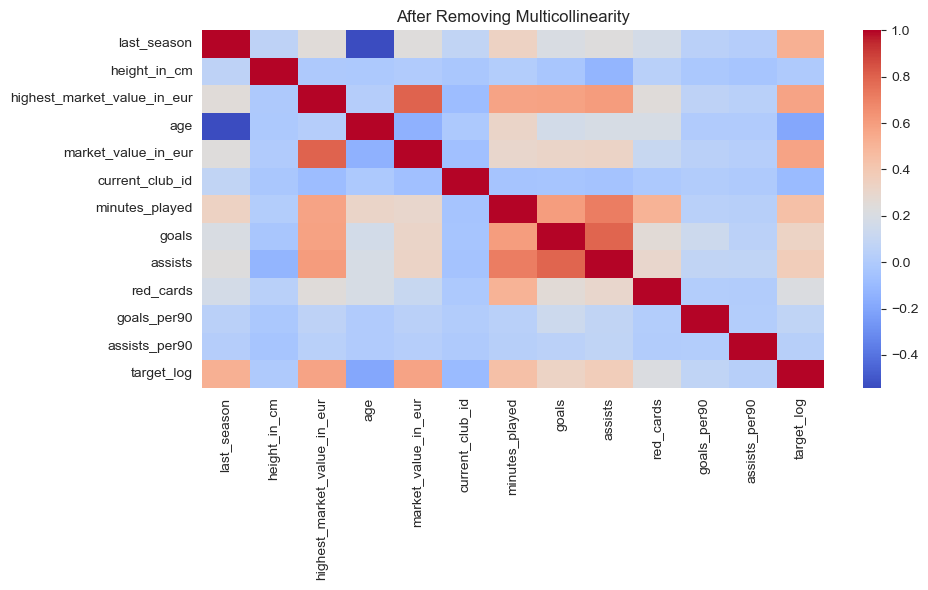

In [8]:
df_reduced = df.drop(columns=['yellow_cards'])
plt.figure(figsize = (10,6))
sns.heatmap(df_reduced.corr(numeric_only=True), cmap='coolwarm')
plt.title('After Removing Multicollinearity')
plt.tight_layout()
plt.show()

In [9]:
df = df.drop(columns = ['yellow_cards'])

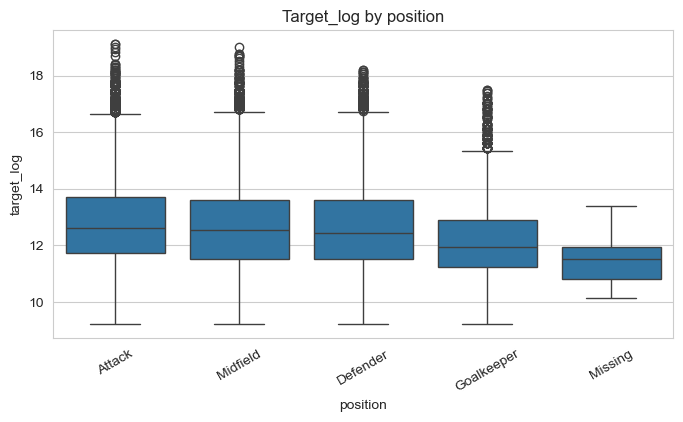

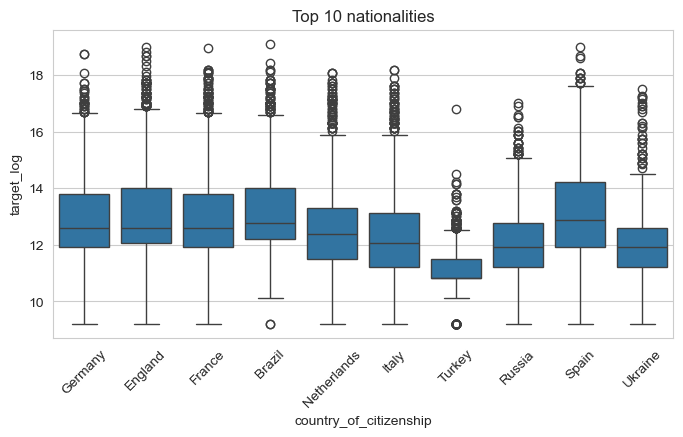

In [10]:
# position effect
if 'position' in df.columns:
    plt.figure(figsize=(8,4))
    order = df.groupby('position')['market_value_in_eur'].median().sort_values(ascending=False).index
    sns.boxplot(data=df, x='position', y='target_log', order=order)
    plt.title('Target_log by position'); plt.xticks(rotation=30); plt.show()

# top nationalities (count > threshold)
if 'country_of_citizenship' in df.columns:
    top_c = df['country_of_citizenship'].value_counts().head(10).index
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df[df['country_of_citizenship'].isin(top_c)],
                x='country_of_citizenship', y='target_log')
    plt.xticks(rotation=45); plt.title('Top 10 nationalities'); plt.show()

In [11]:
# Preparing sample!!
df_sample = df.sample(n=50000, random_state = 42) if df.shape[0] > 50000 else df.copy()

X = df_sample.drop(columns=['market_value_in_eur', 'highest_market_value_in_eur', 'target_log'], errors='ignore')
y = df_sample['target_log']

# basic preprocessing: one-hot small-cardinality categories
use_cat = [c for c in cat_cols if df_sample[c].nunique() < 20] 
use_num = [c for c in numeric_cols if c in df_sample.columns]

# simple ColumnTransformer
ct = ColumnTransformer(transformers = [('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), use_cat)], remainder = 'passthrough')

X = ct.fit_transform(df_sample[use_cat + use_num])
# feature names
ohe_cols = ct.named_transformers_['ohe'].get_feature_names_out(use_cat) if use_cat else []
feature_names = list(ohe_cols) + use_num

y = df_sample['target_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
rf.fit(X_train, y_train)

# importances
imp = pd.Series(rf.feature_importances_, index = feature_names).sort_values(ascending = False)
imp.head(20)

highest_market_value_in_eur                 0.631364
age                                         0.190924
last_season                                 0.046454
current_club_id                             0.021612
minutes_played                              0.019216
height_in_cm                                0.015522
assists_per90                               0.008745
goals_per90                                 0.008277
current_club_domestic_competition_id_TR1    0.005243
goals                                       0.004902
assists                                     0.004705
current_club_domestic_competition_id_IT1    0.002642
red_cards                                   0.002131
current_club_domestic_competition_id_ES1    0.001823
foot_right                                  0.001619
current_club_domestic_competition_id_RU1    0.001617
sub_position_Central Midfield               0.001593
current_club_domestic_competition_id_GB1    0.001585
current_club_domestic_competition_id_FR1    0.

In [12]:
res = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp = pd.Series(res.importances_mean, index=feature_names).sort_values(ascending=False)
perm_imp.head(15)

highest_market_value_in_eur                  1.409883
age                                          0.322157
last_season                                  0.027091
current_club_domestic_competition_id_TR1     0.010680
minutes_played                               0.008608
current_club_id                              0.004329
current_club_domestic_competition_id_IT1     0.004120
current_club_domestic_competition_id_RU1     0.001840
current_club_domestic_competition_id_FR1     0.001247
current_club_domestic_competition_id_GB1     0.000839
current_club_domestic_competition_id_UKR1    0.000551
current_club_domestic_competition_id_GR1     0.000406
current_club_domestic_competition_id_NL1     0.000392
current_club_domestic_competition_id_ES1     0.000365
sub_position_Centre-Forward                  0.000346
dtype: float64

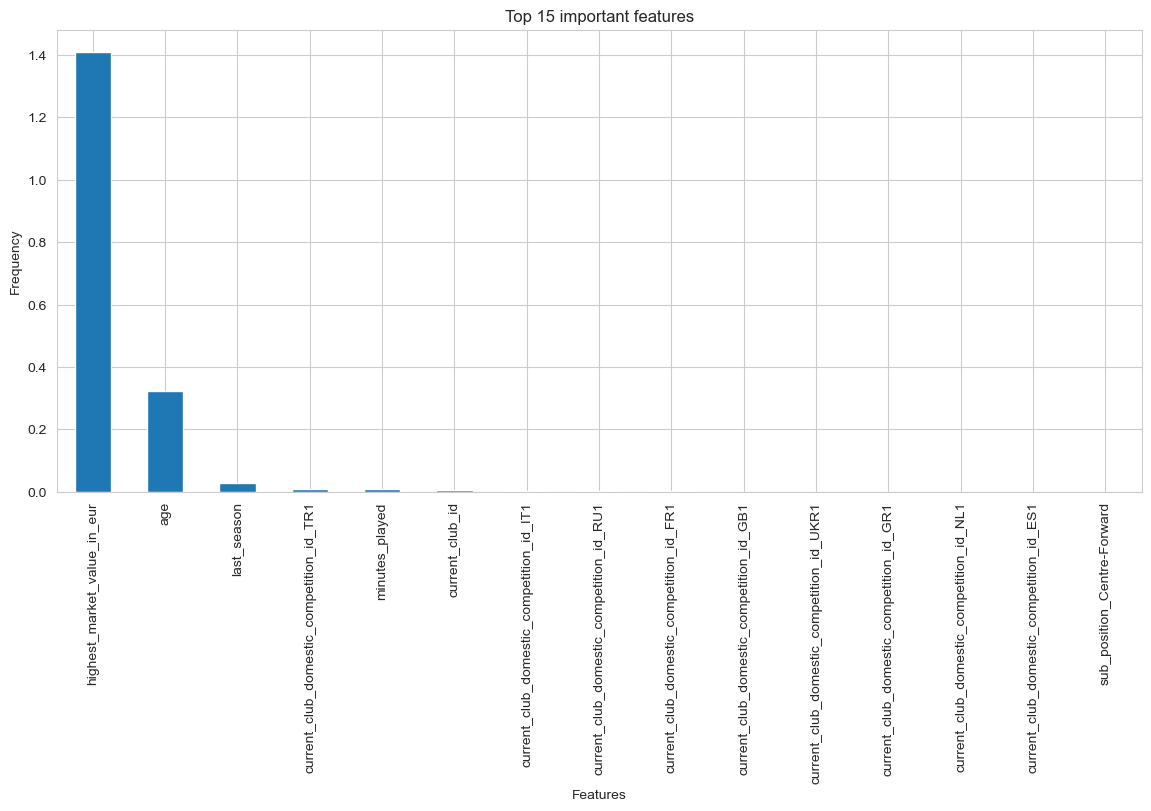

In [13]:
perm_imp.head(15).plot(kind = 'bar', figsize = (14,6), title = 'Top 15 important features'); plt.xlabel('Features'); plt.ylabel('Frequency'); plt.show()

In [14]:
# pick top numeric features + a few categorical flags (example)
selected_features = ['age','minutes_played','goals_per90','assists_per90','position', 'current_club_domestic_competition_id', 'last_season', 'country_of_citizenship']

# ensure they exist
selected = [c for c in selected_features if c in df.columns]
df_model = df[selected + ['market_value_in_eur','target_log']].copy()

df_model.to_csv('/users/kishohars/Projects/football_valuation_project/data_clean/model_ready_selected.csv', index=False)
print("Saved:", df_model.shape)

Saved: (28462, 10)


In [15]:
df_model.head()

,age,minutes_played,goals_per90,assists_per90,position,current_club_domestic_competition_id,last_season,country_of_citizenship,market_value_in_eur,target_log
0,40.0,2989.0,0.030110,0.000000,Defender,DK1,2012,Denmark,50000,10.819798
1,40.0,12858.0,0.000000,0.020999,Goalkeeper,L1,2018,Germany,500000,13.122365
2,40.0,2837.0,0.000000,0.000000,Goalkeeper,GB1,2022,Switzerland,100000,11.512935
3,40.0,8938.0,0.040277,0.100694,Defender,L1,2016,Germany,100000,11.512935
4,40.0,834.0,0.323741,0.431655,Attack,SC1,2013,DR Congo,300000,12.611541
